In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import einsum
import torch.autograd as autograd
import torch.distributions as D
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys
sys.path.append("..")

from src.gof.gof import KSD, GoodnessOfFitTest, PKSD, MaxSKSD
from src.Sliced_KSD_Clean.Divergence.Kernel import *
from src.kernel import RBF
from pymanopt.manifolds import Grassmann

In [9]:
nsample = 100
nbootstrap = 100
torch.manual_seed(1)

In [10]:
mean = torch.Tensor([0])
var = torch.Tensor([1])

# null distribution
null_p = D.Normal(mean, var)

# sample from true distribution
x = 0.5 + torch.randn((nsample, 1)).requires_grad_(True)

In [11]:
k = RBF(sigma=1, method=None)

ksd = KSD(log_prob=null_p.log_prob, kernel=k)
gof_ksd = GoodnessOfFitTest(ksd, x)

In [12]:
gof_ksd.compute_pvalue(nbootstrap)

(array([ 1.24884401e-02,  2.40762548e-02, -1.94772634e-02, -4.55127131e-03,
        -6.53045165e-03, -1.62837981e-02, -1.13329236e-02,  3.31404324e-04,
        -5.81108113e-05, -1.77075560e-03, -9.28629272e-03, -3.31778548e-03,
         4.55534109e-03,  1.03906403e-02, -1.73421796e-02, -1.32384436e-03,
         5.67886568e-03,  3.90273026e-02,  4.79531408e-03, -1.17685587e-02,
        -6.33821295e-03, -8.91362760e-03, -2.64029579e-03,  6.44785664e-03,
        -4.91670189e-03,  1.27891175e-02, -1.80793517e-03, -4.87303623e-03,
         1.28286084e-02, -9.25891979e-03, -3.47442659e-03, -7.15511707e-03,
        -1.17651091e-02,  8.41681735e-04,  6.31570360e-03,  1.19984429e-02,
        -8.37480825e-03, -9.63939081e-03, -1.31554355e-03,  5.04510898e-03,
        -1.04825935e-03,  6.25883854e-03,  1.87411666e-02, -1.41324199e-02,
         2.95531979e-03,  1.93121985e-02, -7.48726246e-03, -6.47642702e-03,
         6.05670348e-04, -3.25440039e-03, -5.77435844e-03, -1.13421774e-02,
        -1.3

# Projected KSD

In [24]:
nsample = 3
nbootstrap = 100
torch.manual_seed(1)

In [25]:
mean = torch.Tensor([0])
var = torch.Tensor([1])

# null distribution
p_null = D.Normal(mean, var)

# sample from true distribution
x = 0.5 + torch.randn((nsample, 1)).requires_grad_(True)
P = torch.Tensor([[1]])

In [51]:
k = RBF(sigma=1, method=None)
manifold = Grassmann(x.shape[1], 1)
    
pksd = PKSD(log_prob=p_null.log_prob, kernel=k, manifold=manifold, P=P)
gof_pksd = GoodnessOfFitTest(pksd, x)

In [48]:
gof_pksd.compute_pvalue(nbootstrap)

(array([-1.92247146e-02, -5.20592750e-03, -1.10279767e-02, -2.39160833e-03,
         7.72265537e-03, -2.76497544e-02,  1.29383052e-02,  1.24100383e-02,
         3.27919008e-02, -5.26624828e-03, -5.33085080e-04, -3.87822170e-04,
        -5.46825827e-03, -2.58032750e-02, -5.53936381e-03, -1.05589670e-02,
         7.46837610e-03,  5.71132904e-03, -1.39205116e-02,  5.45570649e-03,
         4.77603085e-03,  1.11367938e-03, -1.46398039e-02, -5.14878727e-03,
         4.11529499e-02, -1.42979679e-02, -1.09051351e-02,  2.03135278e-02,
        -7.64262462e-03,  2.27896634e-03,  2.36162924e-02,  8.84704602e-03,
         6.15816778e-03, -1.34946047e-02,  1.31069347e-03,  1.23337294e-02,
         1.52318173e-02,  2.89079491e-02,  1.18416854e-02,  5.42621468e-02,
         1.80237925e-02, -3.57650333e-03,  1.61594060e-02, -1.58542450e-02,
        -1.00017680e-02, -2.80556626e-03,  2.30386428e-02, -1.26893456e-02,
         1.77874210e-02, -1.09756249e-02,  1.81995049e-04, -3.17997726e-03,
        -1.5

# 1. $p=q=\mathcal{N}(0, I_d)$

In [120]:
# torch.manual_seed(1)

nsample = 500
nbootstrap = 1000
nrepeat = 100
prop_train = 0.2
sig_level = 0.05

dims = np.concatenate((np.array([1, 2, 5]), np.arange(10, 110, 10)))
# dims = np.array([1, 2, 5, 10])

In [121]:
ksd_stats = [0] * len(dims)
ksd_pvals = [0] * len(dims)
ksd_rejrates = [0] * len(dims)

pksd_pvals = [0] * len(dims)
pksd_rejrates = [0] * len(dims)

maxSKSD_pvals = [0] * len(dims)
maxSKSD_rejrates = [0] * len(dims)

ntrain = int(nsample*prop_train)
for i, dim in enumerate(dims):
    print(f"Running for dim = {dim}")
    ksd_stat = [0] * nrepeat
    ksd_pval = [0] * nrepeat
    pksd_stat = [0] * nrepeat
    pksd_pval = [0] * nrepeat
    
    # null distribution
    mean = torch.zeros(dim)
    var = torch.diag(torch.ones(dim))
    p_null = D.MultivariateNormal(mean, var)

    # alternative distribution
    p_alt = D.MultivariateNormal(mean, var)
    
    P = torch.ones((dim, dim))[:2 :]
    
#     k = RBF(sigma=1, method=None)
    k = RBF(method="med_heuristic")
    manifold = Grassmann(dim, min(2, dim))
    
    for j in tqdm(range(nrepeat)):
        x_ksd = p_alt.sample((nsample, )).requires_grad_(True)
        x_pksd = x_ksd.clone().requires_grad_(True)
        xtrain, xtest = x_pksd[:ntrain, :], x_pksd[ntrain:, :]
        
        ## ksd
        ksd = KSD(log_prob=p_null.log_prob, kernel=k)
        gof_ksd = GoodnessOfFitTest(ksd, x_ksd)
        ksd_boots_val, ksd_stat_val, ksd_pval_val = gof_ksd.compute_pvalue(nbootstrap)
        
        ksd_stat[j] = ksd_stat_val
        ksd_pval[j] = ksd_pval_val
        
#         ## pksd
#         pksd = PKSD(log_prob=p_null.log_prob, kernel=k, manifold=manifold, P=P)
#         _, _ = pksd.train_projection(xtrain, xtrain, epochs=100, delta=1e-4)
#         gof_pksd = GoodnessOfFitTest(pksd, xtest)
#         pksd_boots_val, pksd_stat_val, pksd_pval_val = gof_pksd.compute_pvalue(nbootstrap)
        
#         pksd_stat[j] = pksd_stat_val
#         pksd_pval[j] = pksd_pval_val
        
        ## maxSKSD
        g = torch.eye(xtrain.shape[-1]).requires_grad_()
        r = torch.eye(xtrain.shape[-1])
        optimizer = torch.optim.Adam([g], lr=1e-2, betas=(0.5, 0.9))
        maxSKSD = MaxSKSD(
            log_prob=null_p.log_prob,
            kernel=SE_kernel,
            d_kernel=d_SE_kernel,
            dd_kernel=dd_SE_kernel,
            optimizer=optimizer,
            r=r,
            g=g
        )
        maxSKSD.train_projection(xtrain, xtrain, g=g, epochs=100)
        gof_maxSKSD = GoodnessOfFitTest(maxSKSD, xtest)
        maxSKSD_boots_val, maxSKSD_stat_val, maxSKSD_pval_val = gof_maxSKSD.compute_pvalue(nbootstrap)
        
        maxSKSD_stat[j] = maxSKSD_boots_val
        maxSKSD_pval[j] = maxSKSD_stat_val
        
    ksd_stats[i] = ksd_stat
    ksd_pvals[i] = ksd_pval
    ksd_rejrates[i] = np.mean(np.array(ksd_pval) < sig_level)
    
#     pksd_pvals[i] = pksd_pval
#     pksd_rejrates[i] = np.mean(np.array(pksd_pval) < sig_level)


Running for dim = 1


  0%|          | 0/100 [00:00<?, ?it/s]

Running for dim = 2


  0%|          | 0/100 [00:00<?, ?it/s]

Running for dim = 5


  0%|          | 0/100 [00:00<?, ?it/s]

Running for dim = 10


  0%|          | 0/100 [00:00<?, ?it/s]

Running for dim = 20


  0%|          | 0/100 [00:00<?, ?it/s]

Running for dim = 30


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/100 [00:00<?, ?it/s]

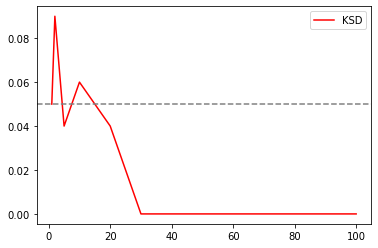

In [122]:
plt.plot(dims, ksd_rejrates, color="r", label="KSD")
# plt.plot(dims, pksd_rejrates, color="b", label="PKSD")
plt.axhline(sig_level, color="grey", linestyle="--")
plt.legend()

In [59]:
# from src.Sliced_KSD_Clean.Divergence.Kernel import *
# g = torch.eye(xtrain.shape[-1]).requires_grad_()
# print(g)
# r = torch.eye(xtrain.shape[-1])
# optimizer = torch.optim.Adam([g], lr=1e-2, betas=(0.5, 0.9))
# maxSKSD = MaxSKSD(
#     log_prob=null_p.log_prob,
#     kernel=SE_kernel,
#     d_kernel=d_SE_kernel,
#     dd_kernel=dd_SE_kernel,
#     optimizer=optimizer,
#     r=r,
#     g=g
# )
# maxSKSD.train_projection(xtrain, xtrain, g=g, epochs=3000)
# gof_maxSKSD = GoodnessOfFitTest(maxSKSD, x)
# print(maxSKSD.g)

# Multivariate Gaussian with effective dims

In [7]:
def gaussian_experiment(dims, nsample, nbootstrap, nrepeat, sig_level=0.05, prop_train=0.2):
    
    ksd_stats = [0] * len(dims)
    ksd_pvals = [0] * len(dims)
    ksd_rejrates = [0] * len(dims)

    pksd_pvals = [0] * len(dims)
    pksd_rejrates = [0] * len(dims)

    ntrain = int(nsample*prop_train)
    for i, dim in enumerate(dims):
        print(f"Running for dim = {dim}")
        ksd_stat = [0] * nrepeat
        ksd_pval = [0] * nrepeat
        pksd_stat = [0] * nrepeat
        pksd_pval = [0] * nrepeat

        # alternative distribution
        mean = torch.zeros(dim)
        cov = torch.diag(torch.ones(dim))
        p_alt = D.MultivariateNormal(mean, cov)

        # null distribution
        mean_null = torch.zeros(dim)
        mean_null[:2] = 1
        cov_null = torch.eye(dim)
        p_null = D.MultivariateNormal(mean_null, cov_null)

        P = torch.ones((dim, dim))[:2 :]

        k = RBF(method="med_heuristic")
        manifold = Grassmann(dim, min(2, dim))

        for j in tqdm(range(nrepeat)):
            x_ksd = p_alt.sample((nsample, )).requires_grad_(True)
            x_pksd = x_ksd.clone().requires_grad_(True)
            xtrain, xtest = x_pksd[:ntrain, :], x_pksd[ntrain:, :]

            ## ksd
            ksd = KSD(log_prob=p_null.log_prob, kernel=k)
            gof_ksd = GoodnessOfFitTest(ksd, x_ksd)
            ksd_boots_val, ksd_stat_val, ksd_pval_val = gof_ksd.compute_pvalue(nbootstrap)

            ksd_stat[j] = ksd_stat_val
            ksd_pval[j] = ksd_pval_val

            ## pksd
            pksd = PKSD(log_prob=p_null.log_prob, kernel=k, manifold=manifold, P=P)
            _, _ = pksd.train_projection(xtrain, xtrain, epochs=100, delta=1e-4)
            gof_pksd = GoodnessOfFitTest(pksd, xtest)
            pksd_boots_val, pksd_stat_val, pksd_pval_val = gof_pksd.compute_pvalue(nbootstrap)

            pksd_stat[j] = pksd_stat_val
            pksd_pval[j] = pksd_pval_val

        ksd_stats[i] = ksd_stat
        ksd_pvals[i] = ksd_pval
        ksd_rejrates[i] = np.mean(np.array(ksd_pval) < sig_level)

        pksd_pvals[i] = pksd_pval
        pksd_rejrates[i] = np.mean(np.array(pksd_pval) < sig_level)
    return(ksd_rejrates, pksd_rejrates, ksd_pvals, pksd_pvals)

In [8]:
dims = [50]
nsample = 100
nbootstrap = 1000
nrepeat = 100
sig_level = 0.05

In [9]:
ksd_rejrates, pksd_rejrates, ksd_pvals, pksd_pvals = gaussian_experiment(
    dims=dims, 
    nsample=nsample, 
    nbootstrap=nbootstrap, 
    nrepeat=nrepeat, 
    sig_level=sig_level
)

Running for dim = 50


  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
print(ksd_rejrates)
print(pksd_rejrates)

[1.0]
[0.93]


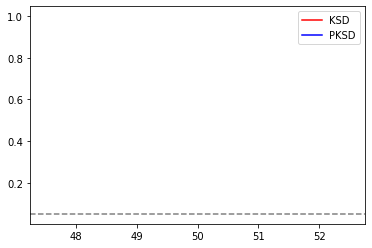

In [10]:
plt.plot(dims, ksd_rejrates, color="r", label="KSD")
plt.plot(dims, pksd_rejrates, color="b", label="PKSD")
plt.axhline(sig_level, color="grey", linestyle="--")
plt.legend()

# Train projection

In [100]:
dim = 10
nsample = 1000
nbootstrap = 1000
nrepeat = 100
sig_level = 0.05

# dims = np.concatenate((np.array([1, 2, 5]), np.arange(10, 110, 10)))
# dims = np.array([1, 2, 5])

# alternative distribution
mean = torch.zeros(dim)
cov = torch.diag(torch.ones(dim))
p_alt = D.MultivariateNormal(mean, cov)

# null distribution
mean_null = torch.zeros(dim)
mean_null[:2] = 1
cov_null = torch.eye(dim)
p_null = D.MultivariateNormal(mean_null, cov_null)

P = torch.ones((dim, dim))[:2 :]
# P = torch.eye(dim)[:2 :]

k = RBF(method="med_heuristic")
manifold = Grassmann(dim, dim)

# ksd = KSD(log_prob=p_null.log_prob, kernel=k)
pksd = PKSD(log_prob=p_null.log_prob, kernel=k, manifold=manifold, P=P)

In [93]:
x = p_alt.sample((nsample, )).requires_grad_(True)

In [94]:
# gof_ksd = GoodnessOfFitTest(ksd, x.detach().requires_grad_(True))
# ksd_boots_val, ksd_stat_val, ksd_pval_val = gof_ksd.compute_pvalue(nbootstrap)

In [101]:
train_prop = 0.2
x_train = x[:int(x.shape[0]*train_prop), :].detach().requires_grad_(True)
x_test = x[int(x.shape[0]*train_prop):, :].detach().requires_grad_(True)
P_ls, stats_ls = pksd.train_projection(x_train, x_train, epochs=100, delta=1e-5)

1.2762399911880493
0.4824410676956177
0.4824410676956177
0.4825945198535919
0.4825945198535919
0.4796704947948456
0.4796704947948456
0.47830668091773987
0.47830668091773987
0.47939029335975647
0.47939029335975647
0.478571355342865
0.478571355342865
0.4766167998313904
0.4766167998313904
0.4765990674495697
0.4765990674495697
0.4752742648124695
0.4752742648124695
0.4754107892513275
0.4754107892513275
0.4750596284866333
0.4750596284866333
0.47432681918144226
0.47432681918144226
0.4740699827671051
0.4740699827671051
0.47397634387016296
0.47397634387016296
0.47340908646583557
0.47340908646583557
0.47333547472953796
0.47333547472953796
0.4731011390686035
0.4731011390686035
0.47164595127105713
0.47164595127105713
0.47042495012283325
0.47042495012283325
0.4690895676612854
0.4690895676612854
0.466279536485672
0.466279536485672
0.46460065245628357
0.46460065245628357
0.4637821614742279
0.4637821614742279
0.46311867237091064
0.46311867237091064
0.46306976675987244
0.46306976675987244
0.46251830458

In [102]:
proj_x = [x_train.detach().numpy() @ proj.T for proj in P_ls]

In [103]:
P_ls

[array([[-0.81878966, -0.18176411, -0.28666866, -0.22803707, -0.20761873,
         -0.05885139, -0.04270434, -0.15407664, -0.28706816, -0.08845873],
        [ 0.45080274, -0.19092117, -0.16478361, -0.24595876, -0.25501812,
         -0.38735855, -0.41626066, -0.2994167 , -0.19681942, -0.39488542]],
       dtype=float32),
 array([[-0.81843466, -0.24267772, -0.2677886 , -0.21622533, -0.19629139,
         -0.08523796, -0.01800279, -0.12878864, -0.2808066 , -0.10606301],
        [ 0.4460094 , -0.15054743, -0.1803469 , -0.25638008, -0.23525192,
         -0.4039132 , -0.40691337, -0.30627117, -0.19345325, -0.4060312 ]],
       dtype=float32),
 array([[-0.8124114 , -0.301341  , -0.24412943, -0.20411165, -0.18728876,
         -0.10531915,  0.00940078, -0.11796885, -0.2679835 , -0.12621859],
        [ 0.44075596, -0.10387611, -0.20255607, -0.26647067, -0.22526503,
         -0.41498554, -0.3971153 , -0.3064807 , -0.19631049, -0.41204643]],
       dtype=float32),
 array([[-0.8026129 , -0.34354186,

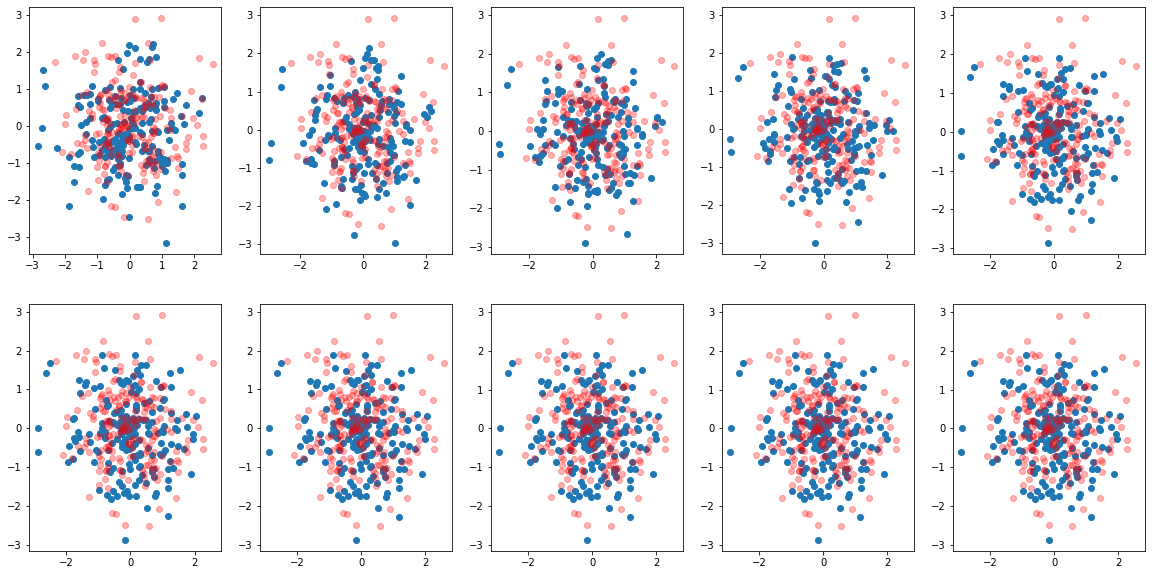

In [104]:
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.ravel()

proj_x_plot = [proj_x[10*i+9] for i in range(10)]
for i, xx in enumerate(proj_x_plot):
    axs[i].scatter(xx[:, 0], xx[:, 1])
    axs[i].scatter(x_train.detach().numpy()[:, 0], x_train.detach().numpy()[:, 1], color="red", alpha=0.3)

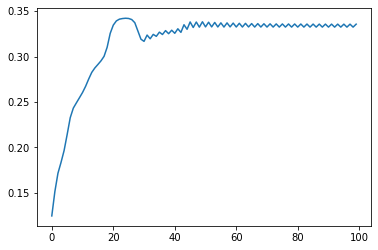

In [105]:
plt.plot(stats_ls)

In [20]:
gof_pksd = GoodnessOfFitTest(pksd, x_test.detach().requires_grad_(True))
pksd_boots_val, pksd_stat_val, pksd_pval_val = gof_pksd.compute_pvalue(nbootstrap)

pksd.P = torch.Tensor(P_ls[0])
gof_pksd2 = GoodnessOfFitTest(pksd, x.detach().requires_grad_(True))
pksd_boots_val2, pksd_stat_val2, pksd_pval_val2 = gof_pksd.compute_pvalue(nbootstrap)

1.5033143758773804
0.5598837733268738
1.5033143758773804
0.5459039807319641


In [21]:
# print(ksd_stat_val, pksd_stat_val, pksd_stat_val2)
# print(ksd_pval_val, pksd_pval_val, pksd_pval_val2)
print(pksd_stat_val, pksd_stat_val2)
print(pksd_pval_val, pksd_pval_val2)

0.27088839374011076 0.0924860893925534
0.0 0.005


# RBM

In [69]:
from src.gof.rbm import GaussianBernoulliRBM, randb

In [70]:
dim_x = 4
dim_h = 2
nsample = 500
nbootstrap = 500
nrepeat = 10

In [71]:
B = randb((dim_x, dim_h))
c = torch.randn((1, dim_h))
b = torch.randn((1, dim_x))
p_null = GaussianBernoulliRBM(B, b, c)
p_alt = GaussianBernoulliRBM(B, b, c)

In [72]:
ksd_stat = [0] * nrepeat
ksd_pval = [0] * nrepeat

for j in tqdm(range(nrepeat)):
    k = RBF(method="med_heuristic")

    x_ksd = p_alt.sample((nsample, ), verbose=False)
    
    ksd = KSD(kernel=k, score=p_null.score)
    gof_ksd = GoodnessOfFitTest(ksd, x_ksd)
    ksd_boots_val, ksd_stat_val, ksd_pval_val = gof_ksd.compute_pvalue(nbootstrap)
    
    ksd_stat[j] = ksd_stat_val
    ksd_pval[j] = ksd_pval_val    

100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


In [74]:
np.mean(np.array(ksd_pval) < 0.05)

0.0

In [79]:
mean = torch.zeros(dim)
cov = torch.diag(torch.ones(dim))
p_alt = D.MultivariateNormal(mean, cov)

In [84]:
p_alt.event_shape[0]

2

In [85]:
ll = [0]*5


In [86]:
ll[0] = (p_null, p_alt)

In [87]:
ll[0]

(GaussianBernoulliRBM(),
 MultivariateNormal(loc: torch.Size([2]), covariance_matrix: torch.Size([2, 2])))

In [90]:
np.arange(0, 0.035, 0.005)

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035])

In [89]:
np.arange(10, 50, 5)

array([10, 15, 20, 25, 30, 35, 40, 45])